# Demo: Used vehicle data for sedans

## Background
I want to find out what the used sedan market looks like in Toronto, so that I can price the sale of a family sized sedan appropriately. Data is taken from a used car trading website with a filter of 50km from my postal code. The web scraping script takes about a few seconds to run. Gathering 15 pages of search results gives us about 1600 entries. The following presents the data cleaning and analysis procedures.

**Purpose**

This is an example of a real-world regression problem. The dataset consists of continuous and categorical data, and we are interested in using this dataset to train machine learning model(s) to predict used vehicle prices.

(Machine Learning -> Supervised Learning -> Regression)

## Step 1: Import the libraries needed and the data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('autotrader.csv')

Let's take a look at what the data looks like. We can see the first 5 rows and all the columns of the dataframe.

In [2]:
df.head()

,Cars,Price,Mileage
0,2015 Audi A3 4dr Sdn quattro 2.0T Technik,"$20,555","Mileage 90,000 km"
1,2015 Hyundai Genesis Sedan 4dr Sdn Technology,"$19,999","Mileage 98,852 km"
2,2013 Audi A6 4dr Sdn quattro 3.0T Premium,"$19,500","Mileage 58,000 km"
3,2016 Hyundai Sonata 4dr Sdn 2.4L Auto GL,"$12,999","Mileage 68,000 km"
4,2016 Kia Forte 4dr Sdn Auto EX w/Sunroof,"$11,900","Mileage 60,000 km"


## Step 2: Data Cleaning
We clean up the 'Price' and 'Mileage' columns by stripping the unwanted texts and converting the contents to numerical values.

In [3]:
df['Mileage'] = pd.to_numeric(df['Mileage'].str.strip('kmMileage,').str.replace(',', ''))
df['Price'] = pd.to_numeric(df['Price'].str.strip('$').str.replace(',',''))

We then parse through the 'Cars' column to extract the useful information. Notice that not all entries are consistent beyond the [Year/Model/Make] format, i.e. some have '4dr' and some don't, we limit the split columns to those 3 categories.

In [4]:
df[['Year','Make','Model','Descr']] = df['Cars'].astype('str').str.split(n=3,expand=True)
df['Age'] = 2020 - pd.to_numeric(df['Year'])

Intuitively, we can claim that the price of a used vehicle depends on how old it is and how much mileage it has. This is a simplified way of pricing because it also depends on presence of cosmetic damages, collision history, and so on, but we ignore those in this exercise. 

We first remove vehicle makes that are not as common from the analysis. Here we empirically define a threshold of 20 counts so that we can drop most of the brands we are not interested in and retain the most entries from the data. 

In [5]:
df_make = df.groupby("Make")
dfm2 = df_make.filter(lambda x: x['Make'].count() > 20)

Since we are interested in pricing a moderately used vehicle, we then remove vehicles with mileage that is too high. Here we define a threshold at 500,000km. Finally, we anticipate that there are luxury vehicles and/or electric vehicles in the data, both are not of interest. We then remove vehicles above the average price of an EV at $45,000.

In [6]:
dfm3 = dfm2[(dfm2.Mileage < 500000) & (dfm2.Mileage > 20000)]
dfm3 = dfm3[dfm3.Price < 45000]

C:\test\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Data kept for analysis: 88 percent of the entire set


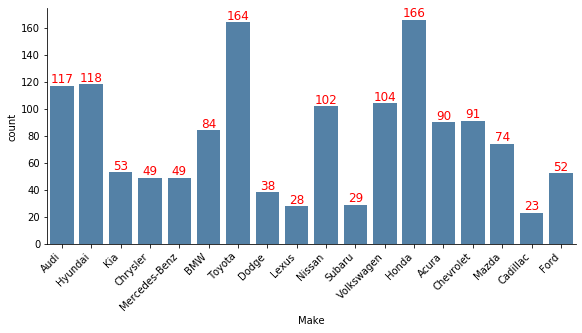

In [7]:
sns.factorplot("Make", data=dfm3, aspect=2, kind="count", color='steelblue', height=4)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')
    
a = ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

print("Data kept for analysis: %d percent of the entire set" % (100 * dfm3['Cars'].count() / df['Cars'].count()))

Notice that not a lot of vehicles are removed from these 3 constraints. We can deduce that perhaps these constraints fostered the removal of outliers as suspected. 

## Step 3: Data Visualization
Let's take a look at what data we have on hand. First we look at some simple description.

Then we look at distributions of prices and mileage.

[Text(0.5, 0, 'Price in CAD'), Text(0.5, 1.0, 'Price distribution')]

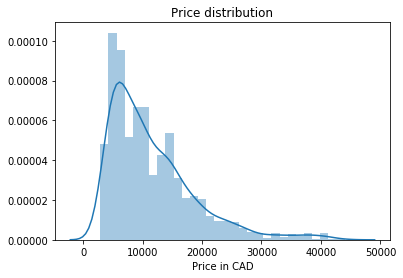

In [8]:
sns.distplot(dfm3['Price'], bins=30).set(title="Price distribution", xlabel="Price in CAD")

[Text(0.5, 0, 'Mileage in km'), Text(0.5, 1.0, 'Mileage distribution')]

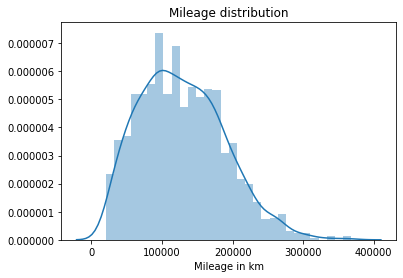

In [9]:
sns.distplot(dfm3['Mileage'], bins=30).set(title="Mileage distribution", xlabel="Mileage in km")

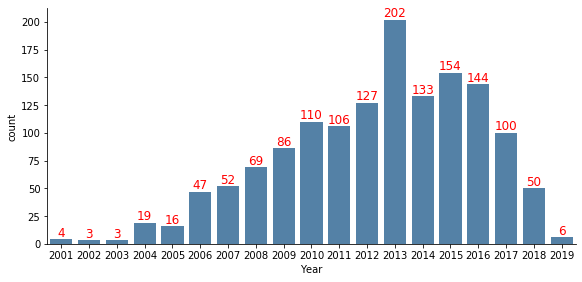

In [10]:
sns.factorplot("Year", data=dfm3, aspect=2, kind="count", color='steelblue', height=4)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')

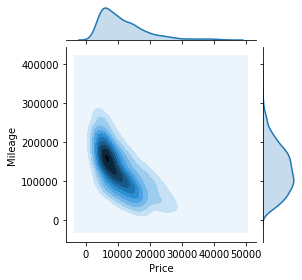

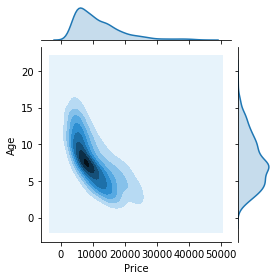

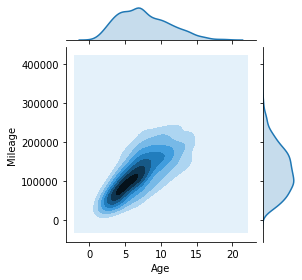

In [11]:
sns.jointplot("Price", "Mileage", dfm3, kind='kde', height=4)
sns.jointplot("Price", "Age", dfm3, kind='kde', height=4)
sns.jointplot("Age", "Mileage", dfm3, kind='kde', height=4)

We can notice a few trends off the bat. As expected, the age of the vehicle positively correlate to the mileage of the vehicle. The older the vehicle, the longer it's been driven. Both the age and the mileage of the vehicle are negatively correlated to the price of the vehicle. The older the vehicle, the lower the offer price. 

## Step 4: Feature Engineering

There is an imbalance in the number of vehicles from each year, and thus throws off the prices and mileage distrbution. Outliers exist in the form of older vehicles that have low mileage and thus higher prices. 

We can also study if the make of the vehicles play a part. There is also an imbalance in the make of the vehicles. E.g. Honda has 173 entries and Ford has 56 entries. 

There are a few ways of dealing with the imbalance issue. One way is to weight some of the features to offset for the imbalance in entries. We can leverage the average age of each make, and create a weighted feature where the age of each vehicle is divided by the respective make average age.

In [12]:
# obtain average age of each make
dfam = dfm3.groupby('Make')["Age"].mean()
dfmm = dfm3.groupby('Make')["Mileage"].mean()
# map to each entry
dfm3['Make_avg_age'] = dfm3['Make'].map(dfam.to_dict())
dfm3['Make_avg_mileage'] = dfm3['Make'].map(dfmm.to_dict())
dfm3['weighted_age'] = dfm3['Age'] / dfm3['Make_avg_age']
dfm3['weighted_mileage'] = dfm3['Mileage'] / dfm3['Make_avg_mileage']
dfm3.drop(columns=['Cars','Descr']).head()

,Price,Mileage,Year,Make,Model,Age,Make_avg_age,Make_avg_mileage,weighted_age,weighted_mileage
0,20555,90000,2015,Audi,A3,5,8.188034,131388.128205,0.610647,0.684993
1,19999,98852,2015,Hyundai,Genesis,5,5.796610,108532.415254,0.862573,0.910806
2,19500,58000,2013,Audi,A6,7,8.188034,131388.128205,0.854906,0.441440
3,12999,68000,2016,Hyundai,Sonata,4,5.796610,108532.415254,0.690058,0.626541
4,11900,60000,2016,Kia,Forte,4,6.547170,116984.735849,0.610951,0.512887


In [13]:
# sns.jointplot("Price", "Annual_usage", dfm3, kind='kde', height=4)
# sns.jointplot("Price", "weighted_age", dfm3, kind='kde', height=4)

The 'Model' feature needs to be encoded before being used as a numerical variable for regression. There are a few ways to encode categorical data. An simple way is **One-Hot encoding**, which is to convert each category value into a new column and assign a 0/1 value to the column. Instead of writing our own encoder, we can use the Pandas built-in One-Hot encoder.

Moving forward here, we are making some simplifying assumptions. 1) The make (or brand) of the vehicle associate with the market segments (luxury/commodity/etc), which is a main driver of the price. So here we are ignoring the model. 2) we acknowledge that the description could change the value of the used vehicle. It could point out desirable features, or note levels of repair needed. One could investigate if the length of the description affects the price, or even use NLP to give value to the words used. We ignore the description in this exercise. 

In [14]:
df_onehot = dfm3.copy()
# df_onehot = df_onehot[["Price","Mileage","weighted_mileage","Make","Age","weighted_age","Annual_usage"]]
df_onehot = df_onehot[["Price","weighted_mileage","Make","weighted_age"]]
df_onehot = pd.get_dummies(df_onehot,columns=['Make'], prefix=[''])

df_onehot.head()

,Price,weighted_mileage,weighted_age,_Acura,_Audi,_BMW,_Cadillac,_Chevrolet,_Chrysler,_Dodge,...,_Honda,_Hyundai,_Kia,_Lexus,_Mazda,_Mercedes-Benz,_Nissan,_Subaru,_Toyota,_Volkswagen
0,20555,0.684993,0.610647,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19999,0.910806,0.862573,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,19500,0.441440,0.854906,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12999,0.626541,0.690058,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,11900,0.512887,0.610951,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Step 5: Model Selection

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_onehot[["weighted_mileage","weighted_age"]] = scaler.fit_transform(df_onehot[["weighted_mileage","weighted_age"]])
# df_onehot[["Mileage","weighted_mileage","Age","weighted_age","Annual_usage"]] = scaler.fit_transform(df_onehot[["Mileage","weighted_mileage","Age","weighted_age","Annual_usage"]])
df_onehot.head()

,Price,weighted_mileage,weighted_age,_Acura,_Audi,_BMW,_Cadillac,_Chevrolet,_Chrysler,_Dodge,...,_Honda,_Hyundai,_Kia,_Lexus,_Mazda,_Mercedes-Benz,_Nissan,_Subaru,_Toyota,_Volkswagen
0,20555,0.205063,0.181856,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19999,0.293237,0.276902,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,19500,0.109961,0.274010,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12999,0.182239,0.211816,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,11900,0.137860,0.181971,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
from sklearn.linear_model import BayesianRidge, ARDRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

X = df_onehot.drop(columns=["Price"])
y = df_onehot["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Fit the Regression models
ard = ARDRegression(compute_score=True)
ard.fit(X_train,y_train)

ols = LinearRegression()
ols.fit(X_train,y_train)

svr = GridSearchCV(SVR(kernel='rbf', gamma=1.),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}, cv=3, n_jobs=-1, verbose=1)
svr.fit(X_train,y_train)

linsvr = GridSearchCV(SVR(kernel='linear', gamma='auto'),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}, cv=3, n_jobs=-1, verbose=1)
linsvr.fit(X_train,y_train)


rf = RandomForestRegressor()

param_grid = { "criterion" : ["mse"]
              , "min_samples_leaf" : [3,5,7]
              , "min_samples_split" : [3,5,7]
              , "max_depth": [5,10]
              , "n_estimators": [100,500]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.4s finished


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   40.4s finished


In [17]:
print('Random Forest: %.3f' %gs.best_score_)
print('SVM Regressor: %.3f' %svr.best_score_)
print('Linear SVM Regressor: %.3f' %linsvr.best_score_)
print('ARD Regressor: %.3f' %ard.score(X_test,y_test))
print('Linear Regression: %.3f' %ols.score(X_test,y_test))

Random Forest: 0.754
SVM Regressor: 0.617
Linear SVM Regressor: 0.632
ARD Regressor: 0.704
Linear Regression: 0.703


(-1, 20)

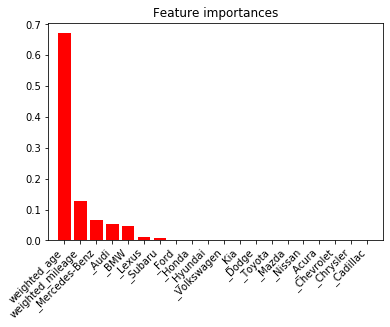

In [18]:
params = gs.best_params_
forest = RandomForestRegressor(criterion=params['criterion'], min_samples_leaf=params['min_samples_leaf'],
                              min_samples_split=params['min_samples_split'], max_depth=params['max_depth'],
                              n_estimators=params['n_estimators'])
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center",tick_label = X_train.columns.values)
# plt.xticks(range(X.shape[1]), indices)

plt.xticks(range(X.shape[1]), X.columns.values[indices],rotation=45,horizontalalignment='right')
plt.xlim([-1, X.shape[1]])

Weighted age turns out to the most dominant feature of all, with weighted mileage in second most important. It is interesting that even after creating weighted features, the makes of Mercedes, Audi, and BMW still managed to be among the most important features. These brands may (and they most likely do) portray a higher standard of quality that retains after the first hand of purchase. 

In [19]:
# sns.regplot(x='Price',y='weighted_age', data=dfm3, logx=True, line_kws={'color':'red'})

## Step 6: Prediction

Let's not get caught up in all the details and lose track of our goal here: to predict used vehicle prices. Foe example, the car we want to sell is a 2015 Hyundai Sonata with 112000km of mileage. 

In [20]:
# Convert to input data and scale the mileage and age.
w_a = 5/dfam['Hyundai']
w_m = 112000/dfmm['Hyundai']
x_raw = np.array([w_m,w_a,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])
x_raw[:2] = scaler.transform(x_raw[:2].reshape(1,-1))

In [21]:
print('Random Forest: %.0f' %gs.predict(x_raw.reshape(1, -1)))
print('SVM Regressor: %.0f' %svr.predict(x_raw.reshape(1, -1)))
print('Linear SVM Regressor: %.0f' %linsvr.predict(x_raw.reshape(1, -1)))
print('ARD Regressor: %.0f' %ard.predict(x_raw.reshape(1, -1)))
print('Linear Regression: %.0f' %ols.predict(x_raw.reshape(1, -1)))

Random Forest: 13403
SVM Regressor: 10824
Linear SVM Regressor: 11231
ARD Regressor: 12174
Linear Regression: 12347


## Conclusion
This demo was meant to showcase my understanding in data interpretation and selection, feature selection and engineering, data visualization, and usage of off-the-shelf ML algorithms. It is interesting to note that a fair price for  this is actually very close and slightly higher than what's predicted by these models.